<a><img style="float: right;" src="https://i.ibb.co/1qVSNwH/FP.png" alt="FP" border="0"></a>

In [100]:
# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 20)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

pd.options.display.float_format = '{:,.5f}'.format

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()

#### Functions ####
def compute_growth_rate(dataframe, initial_value=100, initial_cost=0, ending_cost=0):
    initial_cost = initial_cost / 100
    ending_cost  = ending_cost / 100
    
    GR = ((1 + dataframe.pct_change()).cumprod()) * (initial_value * (1 - initial_cost))
    GR.iloc[0]  = initial_value * (1 - initial_cost)
    GR.iloc[-1] = GR.iloc[-1] * (1 * (1 - ending_cost))
    return GR 

def compute_drawdowns(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / dataframe.cummax() -1) * 100

def compute_return(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe.iloc[-1] / dataframe.iloc[0] -1) * 100
    
def compute_max_DD(dataframe):
    return compute_drawdowns(dataframe).min()

def compute_cagr(dataframe, years=0, investment_value=0):
    '''
    Function to calculate CAGR given a dataframe of prices
    '''
    years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
    
    if investment_value == 0:
        return (dataframe.iloc[-1].div(dataframe.iloc[0]).pow(1 / years)).sub(1).mul(100)
    else:
        return (dataframe.iloc[-1].div(investment_value).pow(1 / years)).sub(1).mul(100)

def compute_mar(dataframe):
    '''
    Function to calculate mar: Return Over Maximum Drawdown
    given a dataframe of prices
    '''
    return compute_cagr(dataframe).div(compute_drawdowns(dataframe).min().abs())

def compute_StdDev(dataframe, freq='days'):    
    '''
    Function to calculate annualized standart deviation
    given a dataframe of prices. It takes into account the
    frequency of the data.
    '''    
    if freq == 'days':
        return dataframe.pct_change().std().mul((np.sqrt(252))).mul(100)
    if freq == 'months':
        return dataframe.pct_change().std().mul((np.sqrt(12))).mul(100)

def compute_sharpe(dataframe, years=0, freq='days'):    
    '''
    Function to calculate the sharpe ratio given a dataframe of prices.
    '''    
    return compute_cagr(dataframe, years).div(compute_StdDev(dataframe, freq))

def compute_return(dataframe, investment_value=0):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    if investment_value == 0:
        return(dataframe.iloc[-1] / dataframe.iloc[0] -1) * 100
    else:
        return(dataframe.iloc[-1] / investment_value -1) * 100

def compute_performance_table(dataframe, years='si', freq='days', investment_value=0):    
    '''
    Function to calculate a performance table given a dataframe of prices.
    Takes into account the frequency of the data.
    ''' 
    
    if years == 'si':
        years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
        
        df = pd.DataFrame([compute_return(dataframe, investment_value), compute_cagr(dataframe, years, investment_value), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['Return', 'CAGR', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        df['Max DD'] = (df['Max DD'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df
    
    else:
        df = pd.DataFrame([compute_return(dataframe, investment_value), compute_cagr(dataframe, years, investment_value), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df

def compute_time_period(timestamp_1, timestamp_2):
    
    year = timestamp_1.year - timestamp_2.year
    month = timestamp_1.month - timestamp_2.month
    day = timestamp_1.day - timestamp_2.day
    
    if month < 0:
        year = year - 1
        month = 12 + month
    
    if day < 0:
        day = - day
        
    # Returns datetime object in years, month, days
    return(str(year) + ' Years ' + str(month) + ' Months ' + str(day) + ' Days')

def filter_by_date(dataframe, years=0, previous_row=False):
    
    last_date = dataframe.tail(1).index
    year_nr = last_date.year.values[0]
    month_nr = last_date.month.values[0]
    day_nr = last_date.day.values[0]
            
    new_date = str(year_nr - years) + '-' + str(month_nr) + '-' + str(day_nr)
    
    if previous_row == False:
        return dataframe.loc[new_date:]
    
    elif previous_row == True:
        return pd.concat([dataframe.loc[:new_date].tail(1), dataframe.loc[new_date:]])
    
def get(quotes):

    # resample quotes to business month
    monthly_quotes = quotes.resample('BM').last()
    
    # get monthly returns
    returns = monthly_quotes.pct_change()

    # get close / first column if given DataFrame
    if isinstance(returns, pd.DataFrame):
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    # get returnsframe
    returns = pd.DataFrame(data={'Retornos': returns})
    returns['Ano'] = returns.index.strftime('%Y')
    returns['Mês'] = returns.index.strftime('%b')

    # make pivot table
    returns = returns.pivot('Ano', 'Mês', 'Retornos').fillna(0)

    # order columns by month
    returns = returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

    return returns

def plot(returns,
         title="Monthly Returns (%)",
         title_color="black",
         title_size=12,
         annot_size=10,
         figsize=None,
         cmap='RdYlGn',
         cbar=False,
         square=False):

    returns = get(returns)
    returns *= 100
    
    if figsize is None:
        size = list(plt.gcf().get_size_inches()) 
        figsize = (size[0], size[0] // 2)
        plt.close()

    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(returns, ax=ax, annot=True,
                     annot_kws={"size": annot_size}, fmt="0.2f", linewidths=0.4, center=0,
                     square=square, cbar=cbar, cmap=cmap)
    ax.set_title(title, fontsize=title_size, color=title_color, fontweight="bold")

    fig.subplots_adjust(hspace=0)
    plt.yticks(rotation=0)
    plt.show()
    plt.close()


PandasObject.get_returns_heatmap = get
PandasObject.plot_returns_heatmap = plot

def calendarize(returns):
    
    '''
    The calendarize function is an slight adaption of ranaroussi's monthly-returns-heatmap 
    You can find it here: https://github.com/ranaroussi/monthly-returns-heatmap/
    
    It turns monthly data into a 12 columns(months) and yearly row seaborn heatmap
    '''
    
    # get close / first column if given DataFrame
    if isinstance(returns, pd.DataFrame):
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    # get returnsframe
    returns = pd.DataFrame(data={'Retornos': returns})
    returns['Ano'] = returns.index.strftime('%Y')
    returns['Mês'] = returns.index.strftime('%b')

    # make pivot table
    returns = returns.pivot('Ano', 'Mês', 'Retornos').fillna(0)

    # order columns by month
    returns = returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

    return returns

def plotly_table(df, width=990, height=500, columnwidth=[25], title=None , index=True, header=True,
                 header_alignment=['center'],  header_line_color='rgb(100, 100, 100)', header_font_size=[12],
                 header_font_color=['rgb(45, 45, 45)'], header_fill_color=['rgb(200, 200, 200)'],
                 cells_alignment=['center'], cells_line_color=['rgb(200, 200, 200)'], cells_font_size=[11], 
                 cells_font_color=['rgb(45, 45, 45)'], cells_fill_color=['rgb(245, 245, 245)','white' ]):
    
    # Making the header bold and conditional  
        if (header == False and index == False):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header.pop(0)
            header =  [[]] + header
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
              
        # Making the header bold and conditional  
        if (header == True and index == True):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = [['']] + header
            
            # Making the index Bold
            lst_i = list(df.index[0 + i] for i in range(len(df.index)))
            index = [[i] for i in lst_i]
            index =  list([[ '<b>' + str(index[0 + i][0]) + '</b>' for i in range(len(df.index))]])
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=index + df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
            
        # Making the header bold and conditional  
        if (header == False and index == True):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = [[]] + header
            
            lst_i = list(df.index[0 + i] for i in range(len(df.index)))
            index = [[i] for i in lst_i]
            index =  list([[ '<b>' + str(index[0 + i][0]) + '</b>' for i in range(len(df.index))]])
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=index + df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
            
        # Making the header bold and conditional  
        if (header == True and index == False):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = header
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
        
        if title == None:
            layout = go.Layout(
                autosize=False,
                height=height,
                width=width,
                margin=dict (l=0, r=0, b=0, t=0, pad=0),
            )
        else:
                layout = go.Layout(
                    autosize=False,
                    height=height,
                    width=width,
                    title=title,
                    margin=dict( l=0, r=0, b=0, t=25, pad=0),
                )

        data = [trace]
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, show_link=False, config={'modeBarButtonsToRemove': ['sendDataToCloud','hoverCompareCartesian'],
                                               'displayModeBar': False})

def compute_portfolio(quotes, weights, Nomes):
    
    # Anos do Portfolio
    Years = quotes.index.year.unique()

    # Dicionário com Dataframes anuais das cotações dos quotes
    Years_dict = {}
    k = 0

    for Year in Years:
        # Dynamically create key
        key = Year
        # Calculate value
        value = quotes.loc[str(Year)]
        # Insert in dictionary
        Years_dict[key] = value
        # Counter
        k += 1

    # Dicionário com Dataframes anuais das cotações dos quotes
    Quotes_dict = {}
    Portfolio_dict = {}

    k = 0    
    
    for Year in Years:
        
        n = 0
        
        #Setting Portfolio to be a Global Variable
        global Portfolio
        
        # Dynamically create key
        key = Year

        # Calculate value
        if (Year-1) in Years:
            value = Years_dict[Year].append(Years_dict[Year-1].iloc[[-1]]).sort_index()
        else:
            value = Years_dict[Year].append(Years_dict[Year].iloc[[-1]]).sort_index()

        # Set beginning value to 100
        value = (value / value.iloc[0]) * 100
        # 
        for column in value.columns:
            value[column] = value[column] * weights[n]
            n +=1
        
        # Get Returns
        Returns = value.pct_change()
        # Calculating Portfolio Value
        value['Portfolio'] = value.sum(axis=1)

        # Creating Weights_EOP empty DataFrame
        Weights_EOP = pd.DataFrame()
        # Calculating End Of Period weights
        for Name in Nomes:
            Weights_EOP[Name] = value[Name] / value['Portfolio']
        # Calculating Beginning Of Period weights
        Weights_BOP = Weights_EOP.shift(periods=1)

        # Calculatins Portfolio Value
        Portfolio = pd.DataFrame(Weights_BOP.multiply(Returns).sum(axis=1))
        Portfolio.columns=['Simple']
        # Transformar os simple returns em log returns 
        Portfolio['Log'] = np.log(Portfolio['Simple'] + 1)
        # Cumsum() dos log returns para obter o preço do Portfolio 
        Portfolio['Price'] = 100*np.exp(np.nan_to_num(Portfolio['Log'].cumsum()))
        Portfolio['Price'] = Portfolio['Price']   

        # Insert in dictionaries
        Quotes_dict[key] = value
        Portfolio_dict[key] = Portfolio
        # Counter
        k += 1

    # Making an empty Dataframe for Portfolio data
    Portfolio = pd.DataFrame()

    for Year in Years:
        Portfolio = pd.concat([Portfolio, Portfolio_dict[Year]['Log']])

    # Delete repeated index values in Portfolio    
    Portfolio.drop_duplicates(keep='last')

    # Naming the column of log returns 'Log'
    Portfolio.columns= ['Log']

    # Cumsum() dos log returns para obter o preço do Portfolio 
    Portfolio['Price'] = 100*np.exp(np.nan_to_num(Portfolio['Log'].cumsum()))
        
    # Round Portfolio to 2 decimals and eliminate returns
    Portfolio = pd.DataFrame(round(Portfolio['Price'], 2))

    # Naming the column of Portfolio as 'Portfolio'
    Portfolio.columns= ['Portfolio']

    # Delete repeated days
    Portfolio = Portfolio.loc[~Portfolio.index.duplicated(keep='first')]

    return Portfolio
    
# Multi_period_return (in CAGR)
def multi_period_return(df, years = 1, days=252):
    shifted = df.shift(days * years)
    One_year = (((1 + (df - shifted) / shifted) ** (1 / years))-1)  * 100
    return One_year

def compute_drawdowns_i(dataframe):
    '''
    Function to compute drawdowns based on 
    the inicial value of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / 100 -1) * 100
        
def print_title(string):
    display(Markdown('**' + string + '**'))
    
def all_percent(df):
    for column in df.columns:
        df[column] = df[column].apply( lambda x : str(x) + '%')
        return df

def preview(df):
    return pd.concat([df.head(3), df.tail(3)])

dimensions=(990, 500)

colorz = ['royalblue', 'orange', 'dimgrey', 'darkorchid']

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### print color.BOLD + 'Hello World !' + color.END

##################################################
### Begin of compute_drawdowns_table function ####
##################################################

### Função auxiliar 1
def compute_time_period(timestamp_1, timestamp_2):
    
    year = timestamp_1.year - timestamp_2.year
    month = timestamp_1.month - timestamp_2.month
    day = timestamp_1.day - timestamp_2.day
    
    if month < 0:
        year = year - 1
        month = 12 + month
    
    if day == 0:
        day = - day
        
    if day < 0:
        month =  month - 1
        if timestamp_1.month not in [1, 3, 5, 7, 8, 10, 12]:
            day = 31 + day
        else:
            day = 30 + day        
        
    # Returns datetime object in years, month, days
    return(str(year) + ' Years, ' + str(month) + ' Months, ' + str(day) + ' Days')

### Função auxiliar 2
def compute_drawdowns_periods(df):
    
    # Input: df of max points in drawdowns (where dd == 0)
    
    drawdown_periods = list()

    for i in range(0, len(df.index)):
      
        drawdown_periods.append(compute_time_period(df.index[i], df.index[i - 1]))
    
    drawdown_periods = pd.DataFrame(drawdown_periods)
    
    return (drawdown_periods)


### Função auxiliar 3
def compute_max_drawdown_in_period(prices, timestamp_1, timestamp_2):
    
    df = prices[timestamp_1:timestamp_2]
    
    max_dd = compute_max_DD(df)
    
    return max_dd

### Função auxiliar 4
def compute_drawdowns_min(df, prices):
    
    # Input: df of max points in drawdowns (where dd == 0)
    
    drawdowns_min = list()

    for i in range(0, len(df.index) - 1):
      
        drawdowns_min.append(compute_max_drawdown_in_period(prices, df.index[i], df.index[i + 1]))
    
    drawdowns_min = pd.DataFrame(drawdowns_min)
    
    return(drawdowns_min)

### Função principal
def compute_drawdowns_table(prices, number=5):

    # input: df of prices
    dd = compute_drawdowns(prices)
    
    max_points = dd[dd == 0].dropna()
        
    data = [0.0] 
  
    # Create the pandas DataFrame
    new_data = pd.DataFrame(data, columns = ['New_data'])

    new_data['Date'] = prices.index.max()

    new_data.set_index('Date', inplace=True)

    max_points = pd.DataFrame(pd.concat([max_points, new_data], axis=1).iloc[:, 0])
    
    dp = compute_drawdowns_periods(max_points)
        
    dp.set_index(max_points.index, inplace=True)
    
    df = pd.concat([max_points, dp], axis=1)
    
    df.index.name = 'Date'
    
    df.reset_index(inplace=True)
    
    df['End'] = df['Date'].shift(-1)
    
    df[0] = df[0].shift(-1)
    
    df['values'] = round(compute_drawdowns_min(max_points, prices), 2)
    
    df = df.sort_values(by='values')
    
    df['Number'] = range(1, len(df) + 1)
    
    df.reset_index(inplace=True)
    
    df.columns = [['index', 'Begin', 'point', 'Length', 'End', 'Depth', 'Number']]
    
    df = df[['Begin', 'End', 'Depth', 'Length']].head(number)
    
    df.iloc[:, 2] = df.iloc[:, 2].apply( lambda x : str(x) + '%')
    
    df.set_index(np.arange(1, number + 1), inplace=True)
               
    for index, row in df['End'].iterrows():
        
        if ( (row[0] == prices.index.max())):# & (prices.iloc[-1][0] < prices.max()) ):
            
            df.iloc[index-1, 1] = float('NaN')

    return(df)

################################################
### End of compute_drawdowns_table function ####
################################################

def compute_r2(x, y, k=1):
    xpoly = np.column_stack([x**i for i in range(k+1)])    
    return sm.OLS(y, xpoly).fit().rsquared

def compute_r2_table(df, benchmark):

# df of prices

    lista = []

    for i in np.arange(0, len(df.columns)):
        lista.append(compute_r2(benchmark, df.iloc[: , i]))
             
    Dataframe = pd.DataFrame(lista)
    
    Dataframe.index = df.columns
    
    Dataframe.columns = [benchmark.name]
    
    return(round(Dataframe.transpose(), 3))

colors = ['royalblue',            # 1 - royalblue
          'dimgrey',              # 2 - dimgrey
          'rgb(255, 153, 51)',    # 3 - orange
          'indigo',               # 4 - Indigo
          'rgb(219, 64, 82)',     # 5 - Red
          'rgb(0, 128, 128)',     # 6 - Teal
          '#191970',              # 7 - Navy
          'rgb(128, 128, 0)',     # 8 - Olive
          '#00BFFF',              # 9 - Water Blue
          'rgb(128, 177, 211)']   # 10 - Blueish

In [139]:
# Downloading funds and creating quotes and returns dataframes

# End = '2017-08-20' # Só activas se quiseres que acabe num dia especifíco 

ISINs = ['DE000A0X7541', 'IE00BGCZ0933', 'IQQ0', 'IWDA']
Nomes = ['Acatis'  , 'VG_GB', 'IQQ0', 'IWDA']

fundos = pd.read_csv('Cotacoes_diarias_all.csv', index_col = 'Date', parse_dates = True)[ISINs]

fundos.columns = Nomes
fundos = fundos.dropna()

In [102]:
#### Normalization to 100 ####
fundos = round((fundos / fundos.iloc[0] * 100), 2)

# Comparação entre Acatis Gané e ETF M

##### Fundos Acatis Gané

- Acatis Gané Value Event Fonds A - Fundo misto Moderado - // [Morningstar](https://www.morningstar.pt/pt/funds/snapshot/snapshot.aspx?id=F000002EX0) // [site oficial](https://www.acatis.de/en/investmentfunds/balanced-funds/acatis-gane-value-event-fonds/?tx_fond_show%5Bfond%5D=15&tx_fond_show%5Baction%5D=show&tx_fond_show%5Bcontroller%5D=Fond&cHash=2c41c215ac21838f8cf93cdbfd4725c4)

##### ETFs/Index Funds

- IWDA - ETF tracker do MSCI World - [Morningstar](https://www.morningstar.pt/pt/etf/snapshot/snapshot.aspx?id=0P0000MLIH) //  [Site oficial em português de versão comparável](https://www.blackrock.com/pt/products/251882/)
- IQQ0 - ETF tracker do MSCI World Minimum Volatility - [Morningstar](https://www.morningstar.pt/pt/etf/snapshot/snapshot.aspx?id=0P0000Y2A1) // [Site oficial em português de versão comparável](https://www.blackrock.com/pt/products/251382/)
- Vanguard Global Bond Index Inv EURH Acc - Fundo índice tracker do Bloomberg Barclays Global Aggregate Bond Index- [Morningstar](IE00BGCZ0933) // [Site oficial](https://global.vanguard.com/portal/site/kiids/pt/en/documents)// [KIID](https://global.vanguard.com/portal/site/loadPDF?country=pt&docId=10417) // [Factsheet](https://global.vanguard.com/portal/site/loadPDF?country=pt&docId=13309)

##### Carteiras ETFs

- Moderada
    - 40% Vanguard Global Bond // 30% IWDA // 30% IQQ0

In [103]:
Begin = fundos.head(1).index
Begin = str(Begin.strftime('%Y-%m-%d'))[8:18]

**Dica:** A interactividade dos gráficos da plotly permite:

    . Zoom (mantenham o clique e arrastem o cursor em simultâneo, em cima do gráfico);
    . Tem uma lista de opções que aparece se forem com o cursor ao canto superior direito;
    . Façam duplo clique no gráfico ou seleccionem a opção Autoscale/Reset Axes para voltar ao normal;
    . Alterem a opção de 'Compare data on hoover' para 'Show closest data on hoover' se vos for mais conveniente;
    . Se clicarem num nome na legenda esse fundo desaparece (clicando de novo ele volta a apetecer).

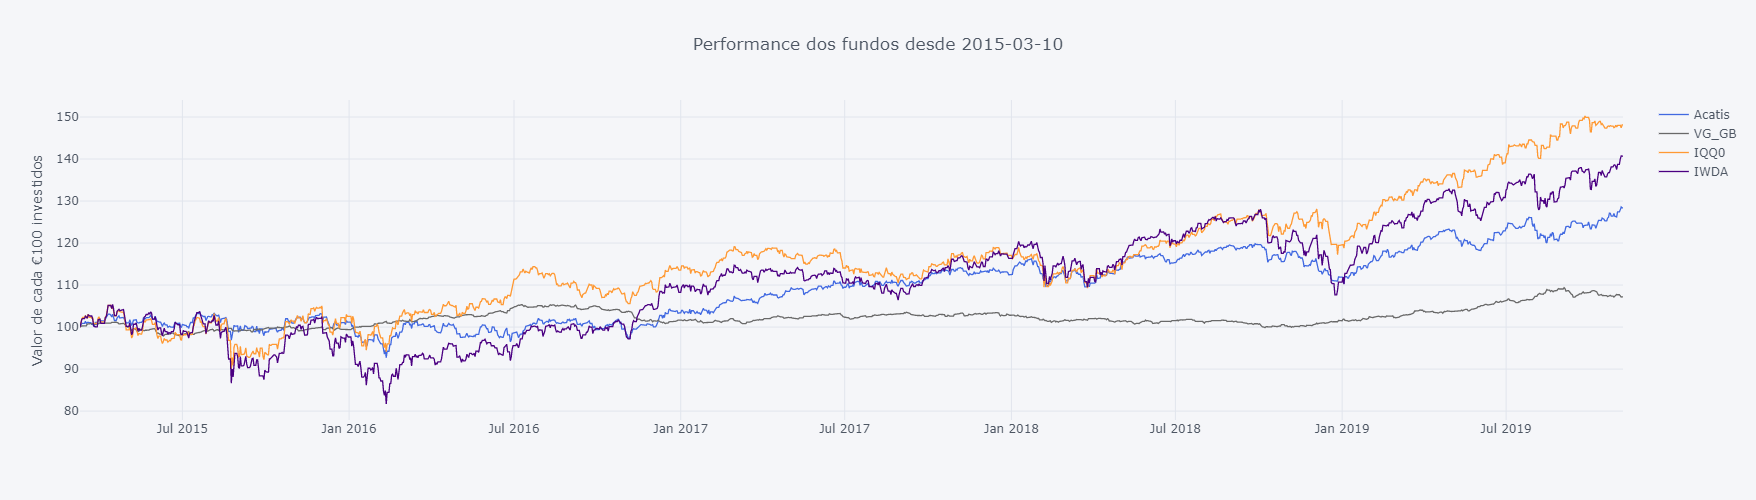

In [104]:
# Making Color Palette
Palette = ['rgb(255, 153, 51)',     # 1 - orange
            'royalblue',            # 2 - Royalblue
            '#708090',              # 3 - Grey
            'rgb(128, 0, 128)',     # 4 - Indigo
            'rgb(219, 64, 82)',     # 5 - Red
            'rgb(0, 128, 128)',     # 6 - Teal
            '#191970',              # 7 - Navy
            'rgb(128, 128, 0)',     # 8 - Olive
            '#00BFFF',              # 9 - Water Blue
            'rgb(128, 177, 211)']   # 10 - 

fundos.iplot(title='Performance dos fundos desde ' + Begin, yTitle='Valor de cada €100 investidos', color=colors, dimensions=dimensions)

**Nota:** Por razões de histórico o fundo obrigaccionista é o Vanguard Global Bond Index. Um fundo índice com uma performance em tudo semelhante com a do AGGH, que é um ETF.

In [105]:
Portfolios = compute_portfolio(fundos, [0, 0.4, 0.3, 0.3], Nomes=Nomes)
Portfolios.columns = ['ETFs_M']
Portfolios['Acatis'] = compute_portfolio(fundos, [1, 0, 0, 0], Nomes=Nomes)

In [106]:
pd.options.display.float_format = '{:,.2f}'.format

print_title('Valores finais dos Portfolios tendo começado em ' + Begin + ' com 100 euros')
Portfolios.tail(1)

**Valores finais dos Portfolios tendo começado em 2015-03-10 com 100 euros**

,ETFs_M,Acatis
2019-11-07,128.84,128.35


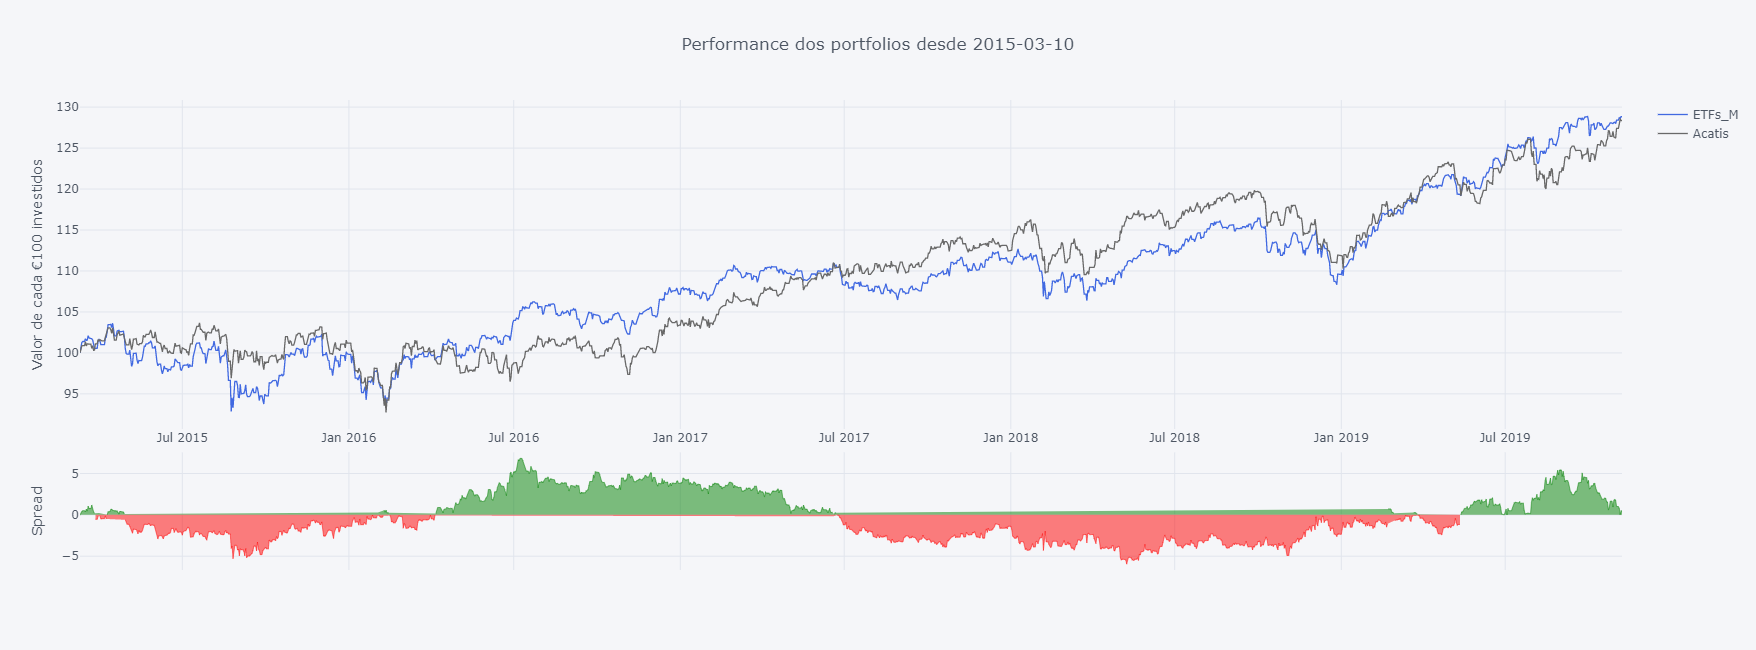

In [107]:
Portfolios.iplot(title='Performance dos portfolios desde ' + Begin, yTitle='Valor de cada €100 investidos', color=colors, dimensions=dimensions_spread, kind='spread')

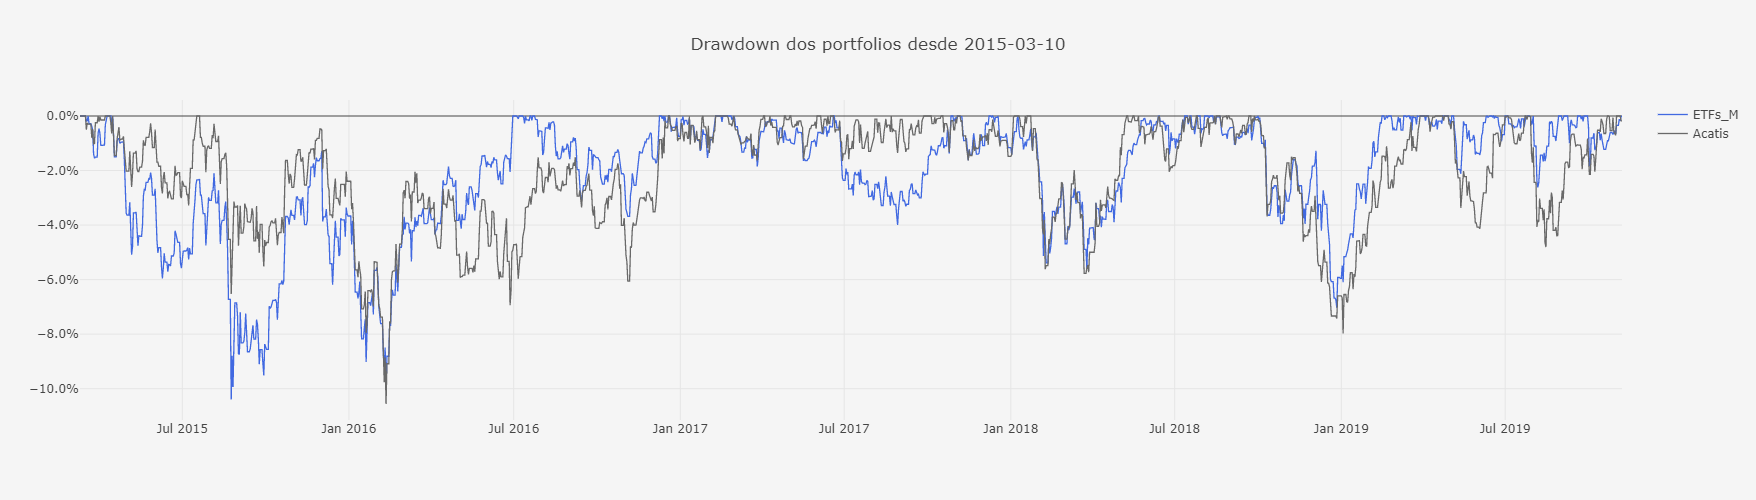

In [108]:
DD = compute_drawdowns(Portfolios)
DD = DD /100

layout = go.Layout(
    title='Drawdown dos portfolios desde ' + Begin,
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#f5f5f5',
    width=990,
    height=500,
    xaxis=dict(
        title='',
        showgrid=True,
        titlefont=dict(size=12),
    ),
    yaxis=dict(
        title='',
        showgrid=True,
        zeroline=True, # Adicionar ou não a zero line
        tickformat=".1%" # tickformat=".2%" se quiseres mais casas decimais
    ))

trace0 = go.Scatter(
    x = DD.index,
    y = DD.iloc[:, 0],
    name = Portfolios.columns[0],
    line = dict(
        color = 'royalblue',
        width = 1.3)
)

trace1 = go.Scatter(
    x = DD.index,
    y = DD.iloc[:, 1],
    name = Portfolios.columns[1],
    line = dict(
        color = 'dimgrey',
        width = 1.3)
)

data = [trace0, trace1]
        
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [109]:
print_title('Drawdown actual (' + str(DD.iloc[-1].name)[0:10] + ')')
DD = compute_drawdowns(Portfolios)
DD = DD /100
round(DD.tail(1), 5).applymap(lambda x: "{0:.2f}%".format(x*100))

**Drawdown actual (2019-11-07)**

,ETFs_M,Acatis
2019-11-07,-0.02%,-0.18%


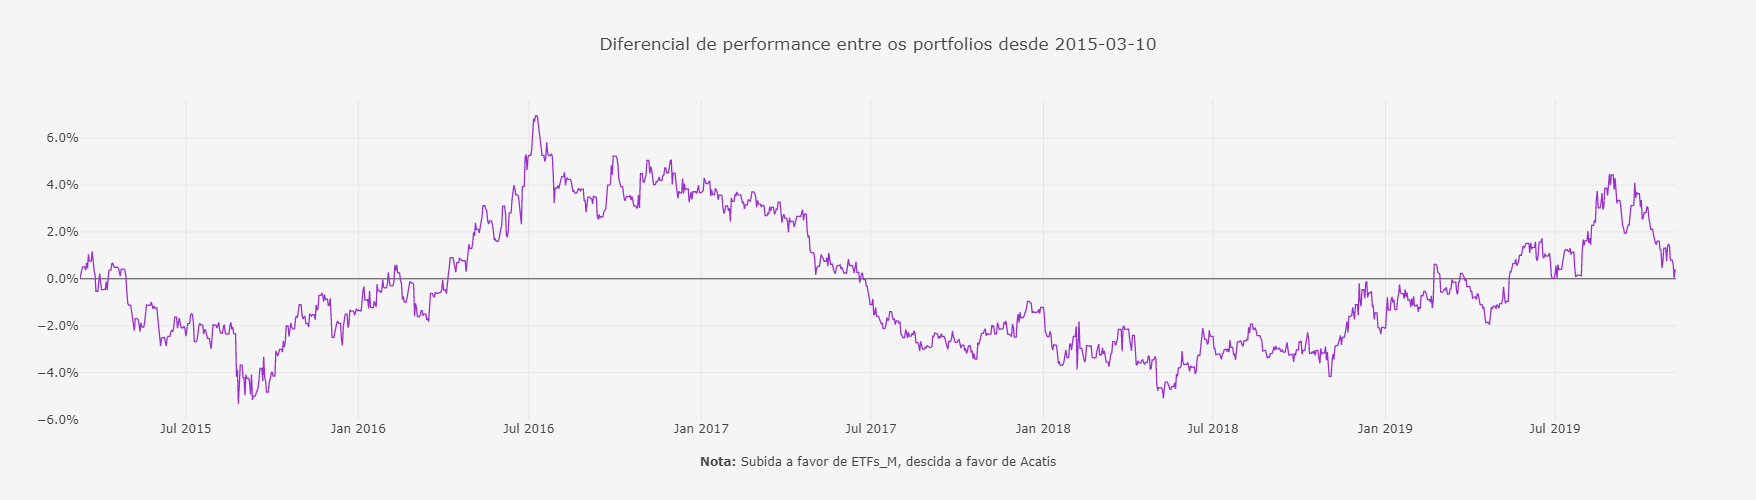

In [110]:
layout = go.Layout(
    title='Diferencial de performance entre os portfolios desde ' + Begin,
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#f5f5f5',
    width=990,
    height=500,
    xaxis=dict(
        title='<b>Nota:</b> Subida a favor de ' + Portfolios.columns[0] + ', descida a favor de ' + Portfolios.columns[1],
        showgrid=True,
        titlefont=dict(size=12),
    ),
    yaxis=dict(
        title='',
        showgrid=True,
        zeroline=True, # Adicionar ou não a zero line
        tickformat=".1%" # tickformat=".2%" se quiseres mais casas decimais
    ))

trace0 = go.Scatter(
    x = fundos.index,
    y = (round(((Portfolios.iloc[:, 0]/Portfolios.iloc[:, 1])- 1), 5)),
    name = 'Portfolio',
    line = dict(
        color = 'darkorchid',
        width = 1.3)
)

data = [trace0]
        
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [111]:
print_title('Performance dos fundos desde ' + Begin)
compute_performance_table(Portfolios)

**Performance dos fundos desde 2015-03-10**

,Return,CAGR,StdDev,Sharpe,Max DD,MAR
ETFs_M,28.84%,5.58%,6.58%,0.85,-10.39%,0.54
Acatis,28.35%,5.49%,6.79%,0.81,-10.56%,0.52


In [112]:
print_title('Performance a 12 meses')
fundos_1 = filter_by_date(Portfolios, years=1)
compute_performance_table(fundos_1)

**Performance a 12 meses**

,Return,CAGR,StdDev,Sharpe,Max DD,MAR
ETFs_M,13.03%,12.99%,5.59%,2.32,-5.83%,2.23
Acatis,8.73%,8.70%,6.69%,1.30,-6.58%,1.32


In [113]:
print_title('Performance a 3 anos')
fundos_3 = filter_by_date(Portfolios, years=3)
compute_performance_table(fundos_3)

**Performance a 3 anos**

,Return,CAGR,StdDev,Sharpe,Max DD,MAR
ETFs_M,24.91%,7.69%,5.29%,1.45,-7.03%,1.09
Acatis,30.03%,9.14%,5.93%,1.54,-7.98%,1.15


- **CAGR:** Retorno geométrico anualizado do portfolio;
- **StdDev:** Desvio padrão anualizado do portfolio (quanto mais alto mais risco tem a carteira);
- **Sharpe:** CAGR/StdDev (quanto mais alto melhor);
- **Max DD:** Maior queda do portfolio;
- **MAR:** CAGR/Max DD (quanto mais alto melhor).

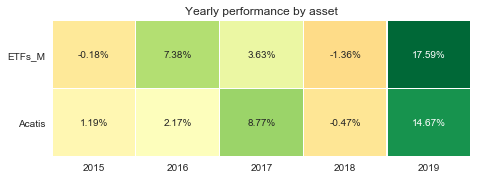

In [114]:
# Compute yearly returns
fundos_norm = Portfolios.copy()

# Resampling to yearly (business year)
yearly_quotes_fundos = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes_fundos = pd.concat([yearly_quotes_fundos.iloc[:1], yearly_quotes_fundos])
yearly_quotes_fundos = pd.concat([pd.DataFrame(fundos_norm.iloc[0]).transpose(), yearly_quotes_fundos.iloc[1:]])

# Returns
yearly_returns_fundos = ((yearly_quotes_fundos / yearly_quotes_fundos.shift(1)) - 1) * 100
yearly_returns_fundos = yearly_returns_fundos.set_index([list(range(fundos_norm.index[0].year - 1, fundos_norm.index[-1].year + 1))]).drop(fundos_norm.index[0].year - 1)

# Calcular em valores percentuais
yearly_returns_fundos = yearly_returns_fundos / 100

# Sns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(len(set(fundos_norm.index.year)) * 1.5,2.5)

ax = sns.heatmap(yearly_returns_fundos.transpose(), annot=True, cmap="RdYlGn", linewidths=.2, cbar=False, center=0.02, fmt='.2%')
plt.yticks(rotation=360)
plt.title('Yearly performance by asset')
plt.show()

In [138]:
print(color.BOLD + 'Nota:' + color.END + 'A performance dos portfolios só foi contablizada desde ' + Begin)

Nota:A performance dos portfolios só foi contablizada desde 2015-03-10


In [129]:
# Compute dradown table
Portfolios = Portfolios.copy()
nr = 0

print_title('Drawdown Table de ' + Portfolios.iloc[:, nr].name)
compute_drawdowns_table(Portfolios.iloc[:, nr])

**Drawdown Table de ETFs_M**

,Begin,End,Depth,Length
1,2015-04-15,2016-06-30,-10.39%,"1 Years, 2 Months, 15 Days"
2,2018-10-01,2019-02-15,-7.03%,"0 Years, 4 Months, 14 Days"
3,2018-01-09,2018-06-14,-5.6%,"0 Years, 5 Months, 5 Days"
4,2017-06-20,2017-10-27,-3.99%,"0 Years, 4 Months, 7 Days"
5,2016-07-24,2016-12-09,-3.68%,"0 Years, 4 Months, 15 Days"


In [128]:
# Compute dradown table
Portfolios = Portfolios.copy()
nr = 1

print_title('Drawdown Table de ' + Portfolios.iloc[:, nr].name)
compute_drawdowns_table(Portfolios.iloc[:, nr])

**Drawdown Table de Acatis**

,Begin,End,Depth,Length
1,2015-07-20,2016-12-19,-10.56%,"1 Years, 4 Months, 29 Days"
2,2018-09-27,2019-03-29,-7.98%,"0 Years, 6 Months, 2 Days"
3,2018-01-23,2018-05-09,-5.77%,"0 Years, 3 Months, 16 Days"
4,2019-07-28,2019-10-22,-4.81%,"0 Years, 2 Months, 24 Days"
5,2019-04-29,2019-07-01,-4.14%,"0 Years, 2 Months, 2 Days"


In [117]:
# Turning daily quotes into monthly
Portfolio_M = Portfolios.resample('BM').last()
# Monthly returns
Portfolio_ret_M = Portfolio_M.pct_change()

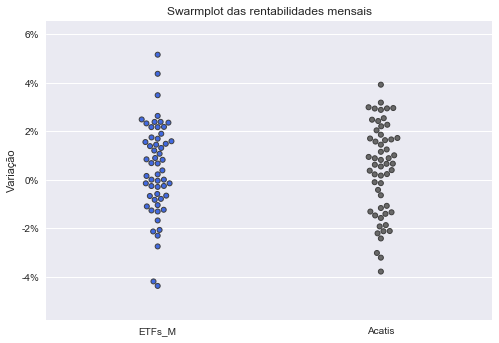

In [118]:
ax = sns.swarmplot(data=Portfolio_ret_M, orient='v', linewidth=1,  palette=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_title("Swarmplot das rentabilidades mensais")
ax.set_xlabel('')
ax.set_ylabel('Variação')
plt.show()

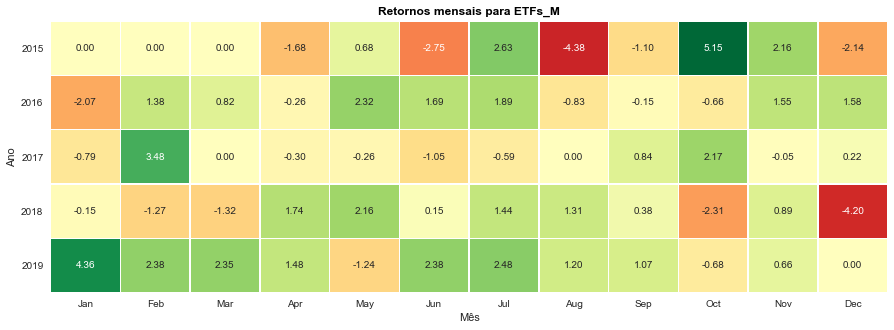

In [124]:
# Compute monthly returns table
Portfolios = Portfolios.copy()
nr = 0

plot(Portfolios.iloc[:, nr], title= 'Retornos mensais para ' + Portfolios.iloc[:, nr].name , figsize=(15, len(np.unique(Portfolios.index.year))))

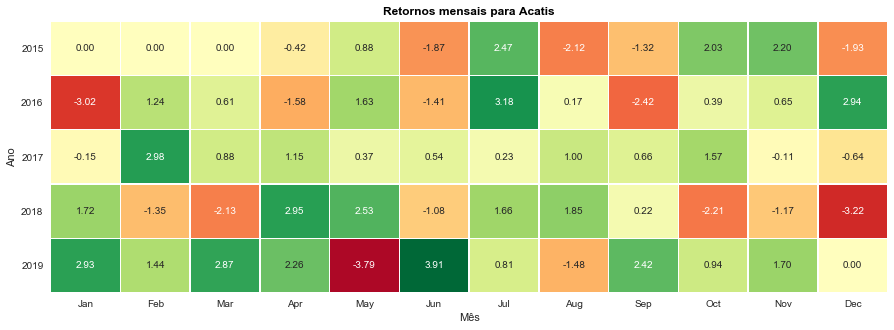

In [126]:
# Compute monthly returns table
Portfolios = Portfolios.copy()
nr = 1

plot(Portfolios.iloc[:, nr], title= 'Retornos mensais para ' + Portfolios.iloc[:, nr].name , figsize=(15, len(np.unique(Portfolios.index.year))))

In [121]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF